In [1]:
import os
import numpy as np
import nrrd
import matplotlib
import matplotlib.pyplot as plt
import pydicom as dicom
import cv2
import cc3d
import pandas as pd
import random
from scipy.ndimage import zoom

In [38]:
# Update this path to point to your local data directory
wd = r'path/to/Data/Classification'
batch = '11th sept'
types = 'Sample d'
ctscan = '3 Pediatric 0.5'
path = os.path.join(wd, batch, types, ctscan)
os.chdir(wd)
os.getcwd()

Raw data shape: (512, 512, 1113)
Raw data min. value: -32722
Raw data max. value: 32755


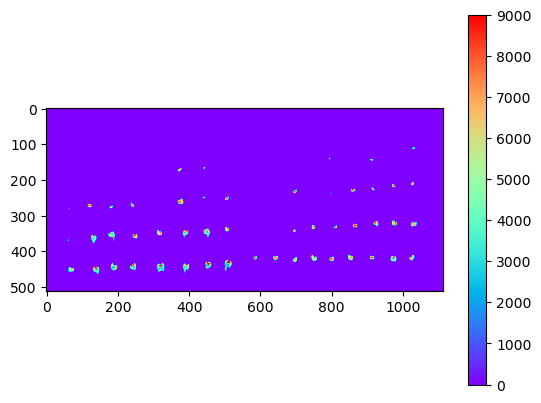

In [39]:
#Read CT Scan batch

#CT raw data
readdata1, header1 = nrrd.read(os.path.join(path, ctscan + ".nrrd"))

print("Raw data shape:", readdata1.shape)

print("Raw data min. value:", np.min(readdata1))
print("Raw data max. value:", np.max(readdata1))


#Show Raw image
#plt.imshow(readdata1[:, readdata1.shape[1]//2, :], cmap = matplotlib.colormaps["rainbow"])
plt.imshow(readdata1[:, 228, :], cmap = matplotlib.colormaps["rainbow"])
plt.clim(0,9000)
plt.colorbar()
plt.show()


In [40]:
# Rescale voxels
xres = 0.43
yres = 0.43
zres = 0.500
target = min(xres, yres, zres)

xf = xres/target
yf = yres/target
zf = zres/target

resized_image = zoom(readdata1, (xf, yf, zf))

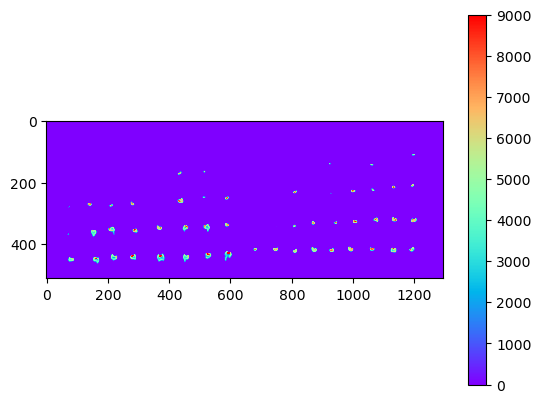

In [41]:
#Show Raw image
plt.imshow(resized_image[:, round(228*yf), :], cmap = matplotlib.colormaps["rainbow"])
plt.clim(0,9000)
plt.colorbar()
plt.show()

In [42]:
readdata1 = resized_image

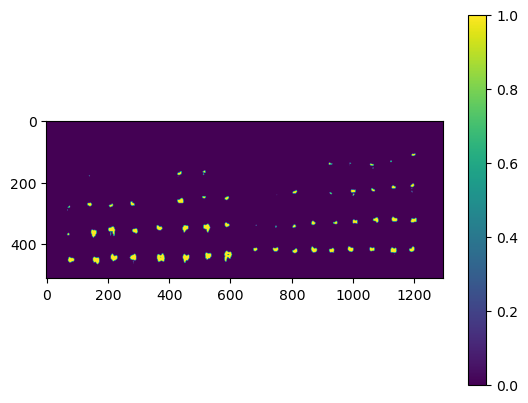

In [43]:
threshold = 0
mask = readdata1.copy()
mask[readdata1 < threshold] = 0
mask[readdata1 >= threshold] = 1

#plt.imshow(mask[:, readdata1.shape[1]//2, :])
plt.imshow(mask[:, round(228*yf), :])
plt.colorbar()
plt.show()

In [44]:
# Isolate each tooth
labels_out, N = cc3d.connected_components(mask, return_N=True, connectivity=6)
labels_out = cc3d.dust(labels_out, threshold=1000)#5000

In [45]:
component_id = np.unique(labels_out)[1:]
component_id

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  73,  74,
        75,  76,  80,  82,  84,  85,  86,  87,  89,  90,  98, 104, 109,
       110, 111, 112, 113, 117, 138, 142, 148, 151, 154, 158, 160, 165,
       168, 179, 180, 190, 194, 201, 204, 205, 212, 222, 223, 228, 229,
       232, 233, 236, 241, 243, 245, 247, 248, 251, 262, 266, 277, 283,
       303, 304, 305, 306, 307, 308, 309, 310, 312, 378, 382, 387, 388,
       389, 391, 404, 409], dtype=uint32)

In [46]:
len(component_id)

82

(19, 18, 56)
19152


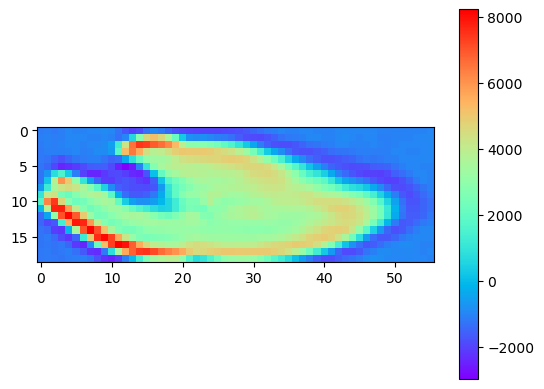

In [47]:
extracted_image = readdata1 * (labels_out == component_id[random.randint(0, len(component_id))])
x, y, z = np.nonzero(extracted_image)
isolated_img = readdata1[x.min():x.max(), y.min():y.max(), z.min():z.max()]

print(isolated_img.shape)
print(isolated_img.shape[0]*isolated_img.shape[1]*isolated_img.shape[2])
plt.imshow(readdata1[x.min():x.max(), int((y.min()+y.max())/2), z.min():z.max()], cmap = matplotlib.colormaps["rainbow"])
plt.colorbar()
plt.show()

In [48]:
# Save files
print('Saving', len(component_id), 'files.')
i = 1
output = [['Batch', 'Type', 'CT Scan', 'Tooth', 'Voxel']]
for id in component_id:
    extracted_image = readdata1 * (labels_out == id)
    x, y, z = np.nonzero(extracted_image)
    isolated_img = readdata1[x.min():x.max(), y.min():y.max(), z.min():z.max()]
    voxel = isolated_img.shape[0]*isolated_img.shape[1]*isolated_img.shape[2]
    if voxel > 100000 or voxel < 1000:
        pass
    else:
        tooth = "Tooth_{:03d}.nrrd".format(i)
        output.append([batch, types, ctscan, tooth, voxel])
        nrrd.write(os.path.join(path, tooth), isolated_img)
        print('\rSaving: Tooth_%03d.nrrd' % i, end='')
        i += 1

df = pd.DataFrame(output[1:],columns=output[0])
df.to_csv(batch + " " + types + " " + ctscan + '.csv', index=False)
df

Saving 82 files.
Saving: Tooth_080.nrrd

,Batch,Type,CT Scan,Tooth,Voxel
0,11th sept,Sample d,3 Pediatric 0.5,Tooth_001.nrrd,20748
1,11th sept,Sample d,3 Pediatric 0.5,Tooth_002.nrrd,23400
2,11th sept,Sample d,3 Pediatric 0.5,Tooth_003.nrrd,19152
3,11th sept,Sample d,3 Pediatric 0.5,Tooth_004.nrrd,19152
4,11th sept,Sample d,3 Pediatric 0.5,Tooth_005.nrrd,17632
...,...,...,...,...,...
75,11th sept,Sample d,3 Pediatric 0.5,Tooth_076.nrrd,21850
76,11th sept,Sample d,3 Pediatric 0.5,Tooth_077.nrrd,21850
77,11th sept,Sample d,3 Pediatric 0.5,Tooth_078.nrrd,16192
78,11th sept,Sample d,3 Pediatric 0.5,Tooth_079.nrrd,17680
